<a href="https://colab.research.google.com/github/Yugi-Seong/AudioDataAugumentation-/blob/main/SpeechAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 **speech augmentation** : **원래 음성 신호를 인위적으로 손상**시켜 네트워크에 새로운 신호를 처리하고 있다는 환상을 제공.   
장점 : 신경망이 일반화를 개선하여 테스트 데이터에서 더 나은 성능을 달성하는 데 도움이 되는 강력한 정규화 장치의 역할을 함.


SpeechBrain 이 지원하는 기능들  
1. speed perturbation (속도섭동)
2. time dropout 
3. frequency dropout
4. clipping 
5. augmentation lobe (1 + 2 + 3)

In [ ]:
# 증강 기술은 speechbrain.processing.speech_augmentation에서 구현됨

# speechbrain 설치 
%%capture
!pip install speechbrain

In [ ]:
# 음성신호 다운로드 

%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

## 1. Speed Perturbation

속도 섭동(변경)을 사용하여 오디오 신호를 원래 신호와 약간 다른 샘플링 속도로 다시 샘플링함. 

원래 신호보다 약간 "빠르거나" "느리게" 들리는 음성 신호. 

말하기 속도뿐만 아니라 음높이 및 포먼트와 같은 스피커 특성에도 영향을 줌.  


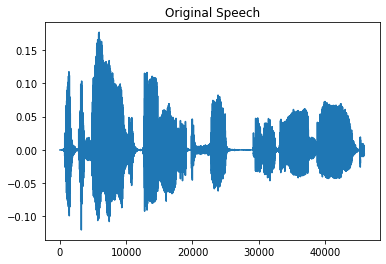

In [ ]:
# 원본 데이터 불러오기 
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio

signal = read_audio('spk1_snt1.wav')

plt.figure(1)
plt.title("Original Speech")
plt.plot(signal)
plt.show()

In [ ]:
# original speech 

from IPython.display import Audio
Audio('spk1_snt1.wav')

In [ ]:
# 속도 섭동 초기화 

# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.processing.speech_augmentation.html#module-speechbrain.processing.speech_augmentation
from speechbrain.processing.speech_augmentation import SpeedPerturb

# 속도 섭동 인스턴스를 생성
perturbator = SpeedPerturb(orig_freq=16000, speeds=[120], perturb_prob=1.0)

# orig_freq : 원래 신호의 주파수 
# speeds : 속도 
# perturb_prob : 배치가 속도 교란될 가능성 

속도 교란기의 세 가지 매개변수

- orig_freq: 원래 신호의 샘플링 주파수
- speegs: 원래 신호의 백분율로 신호를 변경해야 하는 모든 속도를 포함하는 목록  (즉, 속도=[100]은 원래 신호를 변경하지 않음).   
더 많은 값(예: 속도=[90, 100, 110, 120])을 추가하면 속도는 지정된 값 중에서 무작위로 선택됨.)
- perturb_prob: 배치가 교란될 가능성

clean :  tensor([[-9.1553e-05, -9.1553e-05, -9.1553e-05,  ..., -5.3711e-03,
         -5.1880e-03, -5.3711e-03]])
perturbed :  tensor([[-9.0999e-05, -9.5231e-05, -9.1362e-05,  ..., -4.9132e-03,
         -5.7586e-03, -4.6385e-03]])


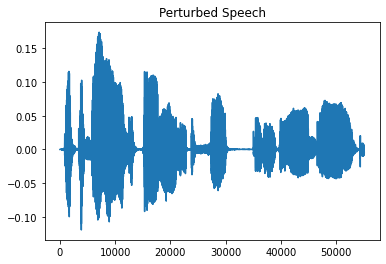

clean.shape :  torch.Size([1, 45920])
perturbed.shape :  torch.Size([1, 55104])


In [ ]:
clean = signal.unsqueeze(0) # [batch, time]
perturbed = perturbator(clean)
print('clean : ', clean)
print('perturbed : ', perturbed)

plt.figure(1)
plt.title("Perturbed Speech")
plt.plot(perturbed.squeeze())
plt.show()

print('clean.shape : ',clean.shape)
print('perturbed.shape : ',perturbed.shape)

Audio(perturbed,rate=16000)


In [ ]:
Audio('spk1_snt1.wav')

# 2. Time dropout
time dropout은 원본 파형의 일부 임의 길이(간격)를 0으로 바꾼 것 (입력 신호의 일부를 삭제 하는 것)  
신경망이 신호의 일부가 누락된 경우(time 채널 누락된 경우)에도 우수한 성능을 제공할 수 있어야 한다는 이론에서 나옴   


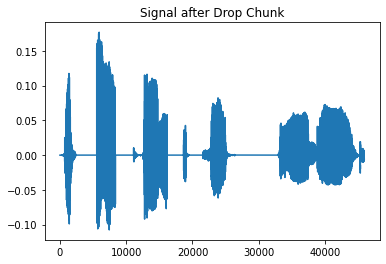

In [ ]:
import torch
# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.processing.speech_augmentation.html#module-speechbrain.processing.speech_augmentation
from speechbrain.processing.speech_augmentation import DropChunk

dropper = DropChunk(drop_length_low=2000, drop_length_high=3000, drop_count_low=5, drop_count_high=10)
# drop_length_low 및 drop_length_high , 0의 임의 청크의 최대 및 최소 길이를 결정 
# drop_count_low 및 drop_count_high, 원래 신호에 추가할 임의의 청크 수에 영향을 줌 

# 길이 벡터는 길이가 다른 신호의 병렬 배치를 처리가능. 
# 길이 벡터는 배치를 구성하는 각 문장에 대한 상대 길이를 포함함
# (예: 두 배치의 경우 lenght=[0.8 1.0]을 가질 수 있음, 1.0은 배치에서 가장 긴 문장의 길이). 
# 이 경우 단일 문장으로 구성된 배치가 있으므로 상대 길이는 length=[1.0].
length = torch.ones(1)
dropped_signal = dropper(clean, length)

plt.figure(1)
plt.title("Signal after Drop Chunk")
plt.plot(dropped_signal.squeeze())
plt.show()

Audio(dropped_signal,rate=16000)


In [ ]:
Audio('spk1_snt1.wav')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency')

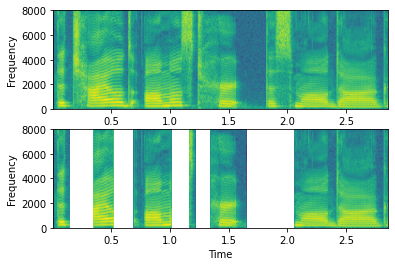

In [ ]:
# Let's plot the two spectrograms
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(dropped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

## 3. Frequency Dropout
주파수 드롭아웃
시간 영역에서 0을 추가하는 대신 Drop Freq는 주파수 영역에서 0을 추가.  
이것은 무작위로 선택된 대역 정지 필터로 원래 신호를 필터링하여 달성가능함.   
time dropout과 유사하게 일부 주파수 채널이 누락된 경우에도 신경망이 잘 작동해야 한다는 원리 이용.




Text(0, 0.5, 'Frequency')

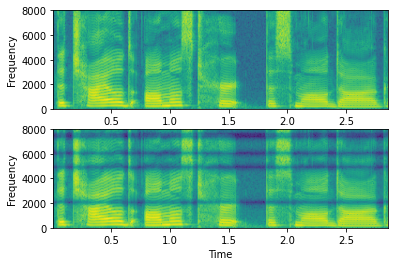

In [ ]:
from speechbrain.processing.speech_augmentation import DropFreq

dropper2 = DropFreq(drop_count_low=5, drop_count_high=8)
dropped_signal_freq = dropper2(clean)

# 주파수 강하의 양 제어 매개변수
# drop_count_low / drop_count_high, 드롭할 주파수 대역 수에 영향을 줌
# drop_freq_low / drop_freq_high, 드롭될 수 있는 최소 및 최대 주파수에 해당
# drop_width 는 드롭할 밴드의 너비에 해당

# Let's plot the two spectrograms
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(dropped_signal_freq.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

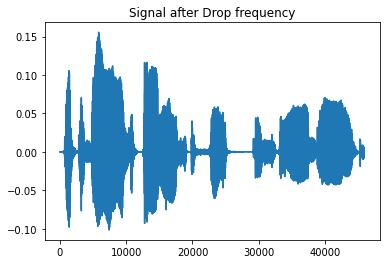

In [ ]:
plt.figure(1)
plt.title("Signal after Drop frequency")
plt.plot(dropped_signal_freq.squeeze())
plt.show()

Audio(dropped_signal_freq,rate=16000)

In [ ]:
Audio('spk1_snt1.wav')

# 4. clipping
음성 신호에서 일부 정보를 제거하는 또 다른 방법은 클리핑을 추가하는 방법이 있음.     
신호의 최대 절대 진폭을 고정하는 비선형 왜곡의 한 형태 -> 포화 효과 추가.

Text(0, 0.5, 'Frequency')

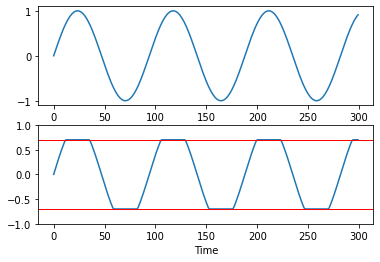

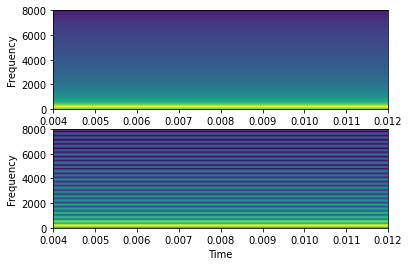

In [ ]:
# 입력 텐서를 클램핑하여 오디오 클리핑을 모방하는 함수 
# => 신호의 최대 절대 진폭을 고정! 

import torch
# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.processing.speech_augmentation.html#module-speechbrain.processing.speech_augmentation
from speechbrain.processing.speech_augmentation import DoClip

# 클리핑 양은 신호가 클램핑되는 하한 및 상한 임계값을 설정하는 매개변수 clip_low 및 clip_high로 제어됨. 
# clip_low ( float ) – 신호를 클리핑할 진폭의 하한.
# clip_high ( float ) – 신호를 클리핑할 진폭의 상한.
clipper = DoClip(clip_low=0.7, clip_high=0.7)

# https://pytorch.org/docs/stable/generated/torch.sin.html?highlight=sin#torch.sin
# https://pytorch.org/docs/stable/generated/torch.linspace.html?highlight=linspace
sinusoid = torch.sin(torch.linspace(0,20, 300))
clipped_signal = clipper(sinusoid.unsqueeze(0))

#  plots
plt.figure(1)
plt.subplot(211)
plt.plot(sinusoid)
plt.xlabel('Time')

plt.subplot(212)
plt.plot(clipped_signal.squeeze())
plt.xlabel('Time')
plt.ylim(-1,1)
# y = 0.7, -0.7 긋기 
plt.axhline(y=0.7, color='r', linewidth=1)
plt.axhline(y=-0.7, color='r', linewidth=1)


# freq domain
plt.figure(2)
plt.subplot(211)
plt.specgram(sinusoid,Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(clipped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

## 5. Augmentation Lobe
speed perturbation, time dropout, frequency dropout 은 종종 특정 확률로 결합되어 사용됨    
SpeechBrain의 Speechbrain.lobes.augment에 TimeDomainSpecAugment 클래스 이용

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


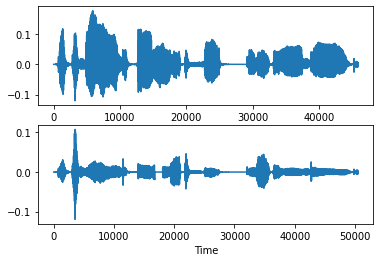

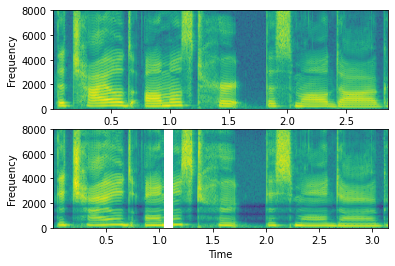

In [ ]:
# speechbrain.lobes.augment에서 이러한 기술을 결합하고 무작위로 활성화하는 인터페이스를 제공
# https://speechbrain.readthedocs.io/en/0.5.7/API/speechbrain.lobes.augment.html#speechbrain.lobes.augment.TimeDomainSpecAugment
from speechbrain.lobes.augment import TimeDomainSpecAugment

do_augment = TimeDomainSpecAugment(speeds=[80, 110, 120],
                                   perturb_prob=1.0, 
                                   drop_freq_prob=1.0, 
                                   drop_chunk_prob=1.0,
                                   drop_chunk_length_low=1000,
                                   drop_chunk_length_high=3000)

length = torch.ones(1)
augmented_signal = do_augment(clean, length)

#  plots
plt.figure(1)
plt.subplot(211)
plt.plot(clean.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.plot(augmented_signal.squeeze())
plt.xlabel('Time')

# freq domain
plt.figure(2)
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(augmented_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(augmented_signal,rate=16000)



- TimeDomainSpecAugment 매개변수

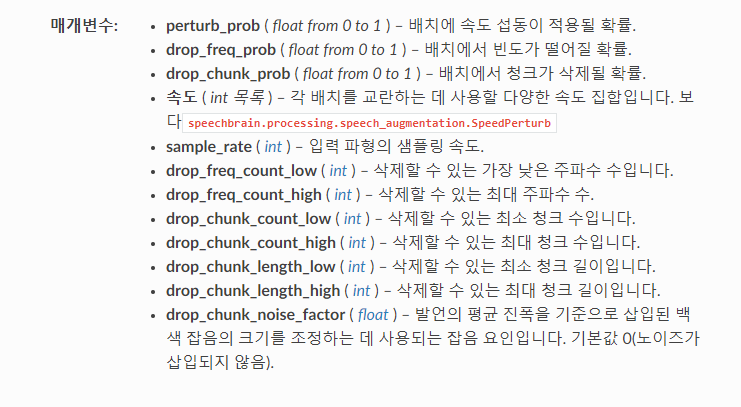

SpeechBrain에서는 종종 즉석 speech augmentation을 수행함     
실제로, 각 epoch에서 생성된 모든 훈련 배치를 다른 방식으로 증가시킴.  
장점 : speech augmentation은 GPU에서 매우 빠르게 구현할 수 있음     
모든 훈련 배치에 대해 즉석에서 수행해도 훈련 루프 속도가 크게 느려지지는 않음.


# References
[1] Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le, *SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition*, Proc. Interspeech 2019, [ArXiv](https://arxiv.org/abs/1904.08779)

[2] Mirco Ravanelli, Jianyuan Zhong, Santiago Pascual, Pawel Swietojanski, Joao Monteiro, Jan Trmal, Yoshua Bengio:
*Multi-Task Self-Supervised Learning for Robust Speech Recognition*. Proc. of ICASSP 2020 [ArXiv]()

# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```